# Lab 06-3: Batch Normalization for DNNs
## Exercise: Predicting MNIST Digits
### For this exercise, prepare Lab 05-3 to copy your previous implementations.

### Prepare Mini MNIST Dataset

In [1]:
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

digits = load_digits()

# digits.data from sklearn contains 1797 images of 8x8 pixels
# Each image has a hand-written digit
digits_df = digits.images.reshape((len(digits.target), -1))
digits_tf = digits.target

# Splitting dataframe into train & test
X_train_org, X_test_org, y_train_num, y_test = train_test_split(digits_df, digits_tf, test_size= 0.20, random_state= 101)

# Digits data has range of [0,16], which often lead too big exponential values
# so make them normal distribution of [0,1] with the sklearn package, or you can just divide them by 16
sc = StandardScaler()
X_train = sc.fit_transform(X_train_org)
X_test = sc.transform(X_test_org)

n_classes = 10

# Transform Nx1 Y vector to Nx10 answer vector, so that we can perform one-to-all classification
y_train = np.zeros((y_train_num.shape[0],10))
for i in range(n_classes):
    y_train[:,i] = (y_train_num == i)

Define Utility Functions

In [2]:
def sigmoid(x):
    # Numerically stable with large exponentials
    x = np.where(x < 0, np.exp(x)/(1 + np.exp(x)), 1/(1 + np.exp(-x)))
    return x

def softmax(x):
    # Numerically stable with large exponentials
    x = x - np.max(x, axis=-1, keepdims=True)
    x = np.exp(x)
    xs = np.sum(x, axis=-1, keepdims=True)
    return x / xs

def create_mini_batches(X, y, batch_size=64):
    # Another implementatioin example of creating mini-batches
    data = np.hstack((X, y))
    np.random.shuffle(data)
    X_batches, y_batches = np.split(data, (X.shape[1],), axis=1)
    X_mini = np.split(X_batches, np.arange(batch_size,len(X),batch_size), axis=0)
    y_mini = np.split(y_batches, np.arange(batch_size,len(X),batch_size), axis=0)
    mini_batches = zip(X_mini, y_mini)
    return mini_batches

Show Dataset Information

(1797, 64)
(1437, 64)
(1437, 10)
[ 0.  0.  0.  9. 16.  6.  0.  0.  0.  0.  4. 15.  6. 15.  0.  0.  0.  0.
  8. 11.  9. 11.  0.  0.  0.  0.  8. 16. 14.  2.  0.  0.  0.  0. 11. 16.
 13.  0.  0.  0.  0.  6. 14.  2. 12.  9.  0.  0.  0.  5. 16. 11.  5. 13.
  4.  0.  0.  0.  3.  8. 13. 16.  9.  0.]


<Figure size 432x288 with 0 Axes>

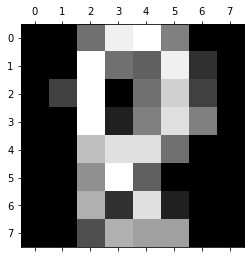

The number is 8


In [3]:
print(digits_df.shape)
print(X_train.shape)
print(y_train.shape)
print(X_train_org[0])

idx = np.random.randint(X_train.shape[0])
dimage = X_train_org[idx].reshape((8,8))
plt.gray()
plt.matshow(dimage)
plt.show()
print('The number is', y_train_num[idx])


### Simple DNN for Digit Classification

Define Model Class with a Dropout Mask<br>
Forward and Backward are same as before (<b>Exercise 05-3</b>)

In [4]:
class myNeuralLayer:
    def __init__(self, n_out, n_in):
        self.wegt = np.zeros((n_out, n_in))
        self.bias = np.zeros((n_out))

    def forward(self, x):       # (b, i)
        ### START CODE HERE ###

        x_lin = np.matmul(x, self.wegt.T) + self.bias            # Linear Prediction
        
        ### END CODE HERE ###
        return x_lin

    def backward(self, x, x_in):  # x = dJ/dz (b, c)
        ### START CODE HERE ###
        
        dw = np.matmul(x.T, x_in) / x.shape[0]               # Gradients for weights
        db = np.mean(x, axis=0)               # Gradients for biases
        wdJdz = np.matmul(x, self.wegt)            # Propagation for lower layer
        
        ### END CODE HERE ###
        return dw, db, wdJdz


Define Backpropagation of Activation Functions (<b>From the previous exercise 05-3</b>)

In [5]:
def dJdz_sigmoid(wdJdz_upper, az):
    ### START CODE HERE ###

    dJdz = wdJdz_upper * az * (1 - az)            # backpropagation through activation function

    ### END CODE HERE ###
    return dJdz

def dJdz_softmax(y_hat, y):
    ### START CODE HERE ###

    dJdz = y_hat - y            # backpropagation through activation function

    ### END CODE HERE ###
    return dJdz

### Define Batch Normalization Layer

Forward Path
$$ \mu_{k,B} = {1 \over m} \sum_{i=1}^{m} x_k^{(i)}, \quad 
\sigma_{k,B}^2 = {1 \over m} \sum_{i=1}^{m} \left( x_k^{(i)} - \mu_{k,B} \right)^2 $$

$$ \hat{x}_k^{(i)} = {{x_k^{(i)} - \mu_{k,B}} \over {\sqrt{\sigma_{k,B}^{2} + \epsilon}}}, \quad 
y_k^{(i)} = \gamma_k \hat{x}_k^{(i)} + \beta_k $$

Backward Path
$$ {\partial J \over \partial \beta_k} = 
\sum_{i=1}^{m} {\partial J \over \partial y_k^{(i)}}, \quad 
{\partial J \over \partial \gamma_k} = 
\sum_{i=1}^{m} \left( {\partial J \over \partial y_k^{(i)}} \cdot \hat{x}_k^{(i)} \right) $$
$$ {\partial J \over \partial x_k^{(i)}} = 
{1 \over \sqrt{\sigma_{k,B}^2 + \epsilon}} \cdot {\partial J \over \partial \hat{x}_k^{(i)}} +
{2 \over m} \left( x_k^{(i)} - \mu_{k,B} \right) {\partial J \over \partial \sigma_{k,B}^{2}} +
{1 \over m} \cdot {\partial J \over \partial \mu_{k,B}} $$

In [6]:
class myBatchNorm:
    def __init__(self, n_out, batch_size):
        # Parameters for Batch Normalization
        self.gamm = np.ones(n_out)                    # trainable variabla
        self.beta = np.zeros(n_out)                   # trainable variable
        self.mean = np.zeros(n_out)                   # running mean 
        self.vari = np.zeros(n_out)                   # running variance

        # Transfering data from forward to backward
        self.t_mean = np.zeros(n_out)                 # mean 
        self.t_xdif = np.zeros((n_out, batch_size))   # diff = x - mu
        self.t_vari = np.zeros(n_out)                 # variance
        self.t_stdv = np.zeros(n_out)                 # stadard deviation
        self.t_invs = np.zeros(n_out)                 # inverse standard deviation
        self.t_xhat = np.zeros((n_out, batch_size))   # x_hat = diff / std_dev
    
    def forward(self, x):
        epsilon = 1e-8
        batch_len = x.shape[0]

        # forward batch normalization
        ### START CODE HERE ###

        self.t_mean = np.mean(x, axis=0)                            # mean, np.mean(hidz_1, axis=0)
        self.t_xdif = x - self.t_mean                            # diff = x - mu
        self.t_vari = np.var(x, axis=0)                            # variance, np.var(), axis=0
        self.t_stdv = np.sqrt(self.t_vari + epsilon)                            # stadard deviation
        self.t_invs = 1 / self.t_stdv                           # inverse standard deviation
        self.t_xhat = self.t_xdif / self.t_stdv                            # x_hat = diff / std_dev
        xout = self.gamm * self.t_xhat + self.beta                                   # output

        ### END CODE HERE ###
        
        return xout

    def backward(self, x):
        momentum = 0.9  # Constant for running mean / variance.
        batch_len = x.shape[0]

        # backward batch normalization
        ### START CODE HERE ###

        dJdb = np.sum(x, axis=0)                                   # dJ/dbeta
        dJdg = np.sum(x * self.t_xhat, axis=0)                                   # dJ/dgamma
        dJdh = self.gamm * x                                   # dJ/dx_hat
        dJdv = np.sum(dJdh * self.t_xdif, axis=0) * (-(self.t_invs**3)/2)                                   # dJ/dv
        dJdm = -self.t_invs * np.sum(dJdh, axis=0) + dJdv * (-2) * np.mean(self.t_xdif, axis=0)                                   # dJ/dm
        dJdx = self.t_invs * dJdh + 2 / batch_len * self.t_xdif * dJdv + dJdm / batch_len                                   # dJ/dx

        # Parameter update
        self.beta = self.beta - 0.01 * dJdb                              # update beta
        self.gamm = self.gamm - 0.01 * dJdg                              # update gamma
        self.mean = momentum * self.t_mean + (1 - momentum) * self.t_mean                               # update mean
        self.vari = momentum * self.t_vari + (1 - momentum) * self.t_vari                              # update variance
        ### END CODE HERE ###
        
        return dJdx

    def predict(self, x):
        epsilon = 1e-8
        # batch normalization layer for prediction
        ### START CODE HERE ###

        x = (x - self.mean) / np.sqrt(self.vari + epsilon)                                      # apply mean and variance
        x = self.gamm * x + self.beta                                      # apply gamma and beta

        ### END CODE HERE ###
        
        return x


In [7]:
np.random.seed(1)
bn = myBatchNorm(3,7)
a = bn.forward(np.random.randn(7,3))
b = bn.backward(np.random.randn(7,3))
c = bn.predict(np.random.randn(7,3))
print('forward:\n', a[0:2])
print('backward:\n', b[0:2])
print('predict:\n', c[0:2])

forward:
 [[ 1.41726481 -0.96839351  0.21649074]
 [-1.08277462  0.93413175 -1.34749376]]
backward:
 [[ 0.98604152  1.06920658  0.27447564]
 [ 1.07963509 -0.40311355  0.04751336]]
predict:
 [[-0.765231    2.04261525  0.70530959]
 [-0.66411125  0.07723286  2.48300419]]


Expected Output:
```
forward:
 [[ 1.41726481 -0.96839351  0.21649074]
 [-1.08277462  0.93413175 -1.34749376]]
backward:
 [[ 0.98604152  1.06920658  0.27447564]
 [ 1.07963509 -0.40311355  0.04751336]]
predict:
 [[ 0.72592995 19.03321851 -1.21365873]
 [ 0.73705164  2.96814124 -4.91310599]]
```

Define Training Functions<br>
<b>Batch Normalization should be implemented (Based on the code from exercise 05-3</b>)

In [34]:
def my_forward(l1, l2, l3, b1, b2, X_in):
    ### START CODE HERE ###

    x_1 = l1.forward(X_in)                    # first linear layer
    h_1 = b1.forward(x_1)                    # first batchnorm layer
    a_1 = sigmoid(h_1)                    # first activation layer
    
    x_2 = l2.forward(a_1)                    # second linear layer
    h_2 = b2.forward(x_2)                    # second batchnorm layer
    a_2 = sigmoid(h_2)                    # second activation layer

    a_3 = softmax(l3.forward(a_2))                    # third stage forward

    ### END CODE HERE ###
    return a_1, a_2, a_3

def my_backward(l1, l2, l3, b1, b2, a_1, a_2, a_3, X_in, y_true):
    ### START CODE HERE ###

    dw_3, db_3, wdJdz_3 = l3.backward(dJdz_softmax(a_3, y_true), a_2)    # go through 3rd stage backward
    dJdz_2 = dJdz_sigmoid(wdJdz_3, a_2)                 # second activation backward
    dJdx_2 = b2.backward(dJdz_2)                 # second batchnorm backward
    dw_2, db_2, wdJdz_2 = l2.backward(dJdx_2, a_1)    # backward through 2ns linear layer
    dJdz_1 = dJdz_sigmoid(wdJdz_2, a_1)                 # first activation backward
    dJdx_1 = b1.backward(dJdz_1)                 # first batchnorm backward
    dw_1, db_1, _       = l1.backward(dJdx_1, X_in)    # backward through 1st linear layer

    ### END CODE HERE ###
    d_1 = [dw_1, db_1]
    d_2 = [dw_2, db_2]
    d_3 = [dw_3, db_3]
    return d_1, d_2, d_3

def my_loss(l1, l2, l3, b1, b2, X_in, y_true):
    ### START CODE HERE ###

    x_1 = l1.forward(X_in)                    # first linear layer
    h_1 = b1.forward(x_1)                    # first batchnorm layer
    a_1 = sigmoid(h_1)                    # first activation layer
    x_2 = l2.forward(a_1)                    # second linear layer
    h_2 = b2.forward(x_2)                    # second batchnorm layer
    a_2 = sigmoid(h_2)                    # second activation layer
    a_3 = softmax(l3.forward(a_2))                    # third stage forward
    loss = -np.mean(y_true * np.log(a_3))                   # calculate loss

    ### END CODE HERE ###
    return loss
    
def my_predict(l1, l2, l3, b1, b2, X_in):
    ### START CODE HERE ###

    x_1 = l1.forward(X_in)                    # first linear layer
    h_1 = b1.forward(x_1)                    # first batchnorm layer
    a_1 = sigmoid(h_1)                    # first activation layer
    x_2 = l2.forward(a_1)                   # second linear layer
    h_2 = b2.forward(x_2)                    # second batchnorm layer
    a_2 = sigmoid(h_2)                    # second activation layer
    a_3 = softmax(l3.forward(a_2))                    # third stage forward
    pred = np.argmax(a_3, axis=1)                   # predict the class
 
    ### END CODE HERE ###
    return pred

Create a NN model and check the matrix dimensions

In [9]:
n_inputs  = 64
n_hidden1 = 80
n_hidden2 = 70
n_classes = 10

l1 = myNeuralLayer(n_hidden1, n_inputs)
l2 = myNeuralLayer(n_hidden2, n_hidden1)
l3 = myNeuralLayer(n_classes, n_hidden2)

print(X_train.shape, y_train.shape)
print(l1.wegt.shape, l1.bias.shape)
print(l2.wegt.shape, l2.bias.shape)
print(l3.wegt.shape, l3.bias.shape)

(1437, 64) (1437, 10)
(80, 64) (80,)
(70, 80) (70,)
(10, 70) (10,)


Expected Output:
```
(1437, 64) (1437, 10)
(80, 64) (80,)
(70, 80) (70,)
(10, 70) (10,)
```

Weight Initialization

In [10]:
def my_initializer(lyr, pdf='normal'):   # probability density function
    (fan_out, fan_in) = w_shape = lyr.wegt.shape                # (c, i)
    if pdf=='normal':
        lyr.wegt = np.random.randn(*w_shape)
    elif pdf=='uniform':
        lyr.wegt = np.random.rand(*w_shape)
    elif pdf=='xavier_normal':           # Xavier is also known as Glorot
        lyr.wegt = np.random.randn(*w_shape) * np.sqrt(2/(fan_out + fan_in))
    elif pdf=='xavier_uniform':
        lyr.wegt = np.random.rand(*w_shape) * np.sqrt(6/(fan_out + fan_in))
    elif pdf=='he_normal':
        lyr.wegt = np.random.randn(*w_shape) * np.sqrt(2/fan_in)
    elif pdf=='he_uniform':
        lyr.wegt = np.random.rand(*w_shape) * np.sqrt(6/fan_in)
    else:
        print('initializer error')
    return

# Weights are initialized to...
weight_init = 'he_normal'

my_initializer(l1, pdf=weight_init)
my_initializer(l2, pdf=weight_init)
my_initializer(l3, pdf=weight_init)

Define Optimizer; Mini-batch SGD only.

In [11]:
class myOptParam:
    def __init__(self, n_out, n_in):
        # Previoud delta values for momentum optimizer
        self.W_dt = np.zeros((n_out, n_in))
        self.B_dt = np.zeros(n_out)
        # Variables for other optimizers
        self.W_mt = np.zeros((n_out, n_in))
        self.B_mt = np.zeros(n_out)
        self.W_vt = np.zeros((n_out, n_in))
        self.B_vt = np.zeros(n_out)
        # Variable for Adam optimizer
        self.iter = 0

def my_optimizer(lyr, opt, W_grad, B_grad, solver='sgd', learning_rate=0.01, iter=0):
    epsilon = 1e-8  # arbitrary small number
    alpha = eta = learning_rate
    if iter!=0:
        opt.iter = iter

    # optimizer routines
    if  solver=='sgd':
        W_dlt = alpha * W_grad
        B_dlt = alpha * B_grad
    else:  
        print('optimizer error')

    # Adjust weight
    lyr.wegt = lyr.wegt - W_dlt
    lyr.bias = lyr.bias - B_dlt

    return

Create Optimizer Parameters

In [12]:
o1 = myOptParam(n_hidden1, n_inputs)
o2 = myOptParam(n_hidden2, n_hidden1)
o3 = myOptParam(n_classes, n_hidden2)

Training Simple Neural Network Model (3 layer model)

In [13]:
# optimizer settings are: 'sgd', 'momentum', 'adagrad', 'rmsprop', 'adam'
# alpha is learning rate
optimizer ='sgd'
alpha = 1e-2      # learning rate
lmbda = 1e-3      # l2 lambda
dpout = 0.5       # dropout rate
n_batch = 64      # batch size

In [14]:
b1 = myBatchNorm(n_hidden1, n_batch)
b2 = myBatchNorm(n_hidden2, n_batch)

In [15]:
n_epochs = 1000

for epoch in range(n_epochs):

    batches = create_mini_batches(X_train, y_train, batch_size=n_batch)
    for one_batch in batches:
        X_mini, y_mini = one_batch
        batch_len = X_mini.shape[0]  # last batch might have different length

        # Forward Path
        a_1, a_2, a_3 = my_forward(l1, l2, l3, b1, b2, X_mini)
        
        # Backward Path
        d_1, d_2, d_3 = my_backward(l1, l2, l3, b1, b2, a_1, a_2, a_3, X_mini, y_mini)

        dw_1, db_1 = d_1
        dw_2, db_2 = d_2
        dw_3, db_3 = d_3
        
        # Update weights and biases
        my_optimizer(l1, o1, dw_1, db_1, solver=optimizer, learning_rate=alpha)
        my_optimizer(l2, o2, dw_2, db_2, solver=optimizer, learning_rate=alpha)
        my_optimizer(l3, o3, dw_3, db_3, solver=optimizer, learning_rate=alpha)

    if ((epoch+1)%100==0):
        loss_J = my_loss(l1, l2, l3, b1, b2, X_train, y_train)
        print('Epoch: %4d,  loss: %10.8f' % (epoch+1, loss_J))

Epoch:  100,  loss: 0.02012475
Epoch:  200,  loss: 0.00881271
Epoch:  300,  loss: 0.00504904
Epoch:  400,  loss: 0.00329515
Epoch:  500,  loss: 0.00234306
Epoch:  600,  loss: 0.00176021
Epoch:  700,  loss: 0.00138161
Epoch:  800,  loss: 0.00112004
Epoch:  900,  loss: 0.00092960
Epoch: 1000,  loss: 0.00078957


Evaluate Model Performance

In [16]:
from sklearn.metrics import accuracy_score

y_pred = my_predict(l1, l2, l3, b1, b2, X_test)

accuracy_score(y_pred, y_test)

0.9861111111111112

Neural Network from scikit-learn

In [17]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(80, 70, ), activation='logistic', solver='sgd', \
                    alpha=0.01, learning_rate_init=0.01, max_iter=1000)

# Training/Fitting the Model
mlp.fit(X_train, y_train_num)

# Making Predictions
s_pred = mlp.predict(X_test)
accuracy_score(s_pred, y_test)

0.975

### Test Model with a random sample


<Figure size 432x288 with 0 Axes>

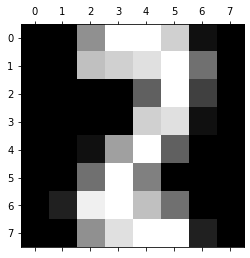

354
[ 0.         -0.33774812  0.79797893  0.97198553  0.97108554  1.27953221
 -0.11255111 -0.12996005 -0.06103492 -0.62723734  0.29302407  0.2541609
  0.77442859  1.30104426  1.39080176 -0.13788933 -0.04991522 -0.71668518
 -1.73861489 -1.20423153 -0.18012702  1.31032548  0.63230214 -0.1254162
 -0.02638899 -0.77557418 -1.46428092 -1.49744919  0.51812461  1.09795751
 -0.35853971 -0.0528332   0.         -0.66509509 -1.03874611  0.15025238
  0.95978599 -0.47895331 -0.82287384  0.         -0.05980442 -0.53502797
  0.03197336  1.36692002  0.07089916 -1.49041367 -0.81085566 -0.09209335
 -0.03682402  0.76328181  1.32279479  1.23835455  0.4920343  -0.32176458
 -0.77525535 -0.21622453 -0.02638899 -0.29648738  0.6843522   0.43064334
  0.84846559  1.55018141 -0.03204287 -0.19864951]
[[ 0.         -0.33774812  0.79797893  0.97198553  0.97108554  1.27953221
  -0.11255111 -0.12996005 -0.06103492 -0.62723734  0.29302407  0.2541609
   0.77442859  1.30104426  1.39080176 -0.13788933 -0.04991522 -0.716685

In [46]:
idx = np.random.randint(X_test.shape[0])
dimage = X_test_org[idx].reshape((8,8))
plt.gray()
plt.matshow(dimage)
plt.show()

X_input = np.expand_dims(X_test[idx], 0)

y_pred = my_predict(l1, l2, l3, b1, b2, X_input)

s_pred = mlp.predict(X_input)

print('My prediction is ' + str(y_pred[0]))
print('sk prediction is ' + str(s_pred[0]))
print('Actual number is ' + str(y_test[idx]))
